<a href="https://colab.research.google.com/github/jainxy/retinanet_task/blob/master/Retinanet_serving_selfDrivingDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
**In this notebook, we run inference over the test-subset of Udacity self-driving-car dataset-1, using API requests on model served using TF-serving.**

---



# Installation and Setup environment

#### Install required packages

In [17]:
## keras-retinanet to use compatible pretrained retinanet backbone
!git clone https://github.com/fizyr/keras-retinanet.git
%cd keras-retinanet/
!pip install .
!python setup.py build_ext --inplace
%cd -

# keras and tensorflow packages
!pip install --upgrade keras

# Install correct version of cocoapi
!pip uninstall -y pycocotools
!git clone https://github.com/cocodataset/cocoapi
%cd cocoapi/PythonAPI
!python setup.py install
%cd -

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 5699 (delta 24), reused 36 (delta 15), pack-reused 5620
Receiving objects: 100% (5699/5699), 14.07 MiB | 15.56 MiB/s, done.
Resolving deltas: 100% (3794/3794), done.
/content/dataset/keras-retinanet
Processing /content/dataset/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=170856 sha256=32732df218ebce6eea10d8384074d9cadd1b30884dc1d6dc2e5acd7597750048
  Stored in directory: /root/.cache/pip/wheels/7a/b7/f6/3724550032ed0944828e04216bfc7c9c95314d99adf90bf551
Successfully built keras-retinanet
  Found existing installation: keras-retinanet 0.5.1
    Uninstalling keras-retinanet-0.5.1:
      Successfully uninstalled keras-retinanet-0.5.1


running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/dataset/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/comp

#### Import packages

In [39]:
%tensorflow_version  1.x  # Ensure tensorflow 2.x package is imported 
import tensorflow as tf  # Tensorflow 2.x package.
# import tensorflow_hub as hub  # Tensorflow Hub package to get pretrained models.
from tensorboard import notebook # tensorboard to manage in-notebook Tensorboard instances
print(tf.version)
# %load_ext tensorboard # load the TensorBoard notebook extension

import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

import cv2
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from PIL import Image
from google.colab import drive

import os, time, sys, glob, pathlib
import urllib
import json
import base64
import requests
from pprint import pprint
from tqdm import tqdm, trange

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x  # Ensure tensorflow 2.x package is imported`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
<module 'tensorflow._api.v1.version' from '/tensorflow-1.15.2/python3.6/tensorflow_core/_api/v1/version/__init__.py'>


#### Functions & Classes

In [0]:
def check_create_path(path):
  '''
  Check if path exists else create
  '''
  if not os.path.exists(path):
    os.makedirs(path)
    print("Created Path - ", path)
  else:
    print("Path - ", path, " exists!")

def draw_bbox(img, bbox, color, thickness=20, label = None):
    """ Draws a bounding-box on an image with a given color.
    # Arguments
        img     : The image to draw on.
        bbox       : A list of 4 elements (x1, y1, x2, y2).
        color     : The color of the box.
        thickness : The thickness of the lines to draw a box with.
    """
    bbox = np.array(bbox).astype(int)
    print(bbox)
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness, cv2.LINE_AA)
    if label is not None:
        font = cv2.FONT_HERSHEY_PLAIN
        fontColor = (255, 255, 255)
        cv2.putText(img, label.upper(), (bbox[0], bbox[1] - 10), font, 8, fontColor, 15)

def disp_objects_img(img_row, data_path):
    img_name = img_row.Frame
    img_path = os.path.join(data_path, img_name)
    bbox = [img_row.xmin, img_row.ymin, img_row.xmax, img_row.ymax]
    label = img_row.Label
    img = cv2.imread(img_path)

    img_draw = img.copy()
    img_draw = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)

    draw_bbox(img_draw, bbox, color=(255, 255, 0), label=label)

    plt.axis('off')
    plt.imshow(img_draw)
    plt.show()

def mount_gdrive():
  drive.mount('/content/gdrive')
  return "/content/gdrive/My Drive/"

# functions for inference
def predict(image, tfClient, score_thresh=None):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  # Create a request json dict
  req_json = {
      "instances": [{"image": image.tolist()}]
  }
  result = tfClient._query_service(req_json)[0]
  x, y, z = result.values()
  for item in [x,y,z]:
    # print(type(item))
    if isinstance(item[0], list):
      boxes = np.array(item)
    elif isinstance(item[0], int):
      labels = np.array(item)
    elif isinstance(item[0], float):
      scores = np.array(item)
    else:
      print("Some issue with the predicted result!")

  boxes /= scale

  if score_thresh is not None:
    labels = labels[scores>score_thresh]
    boxes = boxes[scores>score_thresh,:]
    scores = scores[scores>score_thresh]

  return boxes, scores, labels

def draw_detections(image, boxes, scores, labels, score_thresh):
  for box, score, label in zip(boxes, scores, labels):
    if score < score_thresh:
        break

    color = label_color(label+8)

    b = box.astype(int)
    draw_box(image, b, color=color, thickness=10)
    name = labels_to_names[label]
    print(name)
    caption = "{} {:.3f}".format(name, score)
    draw_caption(image, b, caption)

def show_detected_objects(image_row, data_dir, tfClient, score_thresh):
  img_path = os.path.join(data_dir, image_row.Frame)
  
  image = cv2.imread(img_path)

  boxes, scores, labels = predict(image, tfClient)

  img_draw = image.copy()
  img_draw = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)

  true_box = [
    image_row.xmin, image_row.ymin, image_row.xmax, image_row.ymax
  ]
  draw_box(img_draw, true_box, color=(255, 255, 255), thickness=10)

  draw_detections(img_draw, boxes, scores, labels, score_thresh)

  plt.axis('off')
  plt.imshow(img_draw)
  plt.show()

def gen_pred_df(test_df, data_path, tfsClient, score_thresh):
  '''
  Generate Prediction dataframe for the testset
  '''
  # create empty dataframe
  col_list = list(test_df.columns)
  col_list.append('score')
  df_pred = pd.DataFrame(columns=col_list)
  # parse each image in the testset
  nTest = len(test_df.Frame.unique())
  start_time = time.perf_counter()
  for i, frame in enumerate(test_df.Frame.unique()):
    imgpath = os.path.join(data_path, frame)
    img = cv2.imread(imgpath)
    boxes, scores, labels = predict(img, tfsClient, score_thresh)
    # Fill dataset
    for box, score, label in zip(boxes, scores, labels):
      row_d = dict(Frame = frame,
                  xmin = int(box[0]),
                  ymin = int(box[1]),
                  xmax = int(box[2]),
                  ymax = int(box[3]),
                  Label = label,
                  score = round(score,3))
      df_pred = df_pred.append(row_d, ignore_index=True)
    if i%10 ==0:
      total_time = time.perf_counter() - start_time
      print("Inferenced on {}/{} image".format(i+1, nTest))
      if i>0: print("FPS: {}".format(round(10/total_time, 3)))
      start_time = time.perf_counter()

  return df_pred

In [41]:
# Define a Base client class for Tensorflow Serving

class TFServingClient:
    """
    This is a base class that implements a Tensorflow Serving client
    """
    TF_SERVING_URL_FORMAT = '{protocol}://{hostname}:{port}/v1/models/{endpoint}:predict'

    def __init__(self, hostname, port, endpoint, protocol="http"):
        self.protocol = protocol
        self.hostname = hostname
        self.port = port
        self.endpoint = endpoint
        self.server_url = self.TF_SERVING_URL_FORMAT.format(protocol=self.protocol,
                                                       hostname=self.hostname,
                                                       port=self.port,
                                                       endpoint=self.endpoint)

    def _query_service(self, req_json):
        """

        :param req_json: dict
        :return: dict
        """
        response = requests.post(self.server_url, json=req_json)
        response.raise_for_status()
        return np.array(response.json()['predictions'])


# Instantiate a client
HOSTNAME = "34.69.233.70"
PORT = "8501"
ENDPOINT ="retinanet"
tfs_client = TFServingClient(hostname=HOSTNAME, port=PORT, endpoint=ENDPOINT)
print("Serving URL - ", tfs_client.server_url)

Serving URL -  http://34.69.233.70:8501/v1/models/retinanet:predict


#### Global/Constants/Flags

In [0]:
STORAGE_USE_GDRIVE = False  # Use google-drive for persistent storage and training checkpoints

_URL_IMG = "https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz"
_URL_LABEL = "https://raw.githubusercontent.com/udacity/self-driving-car/master/annotations/labels_crowdai.csv"

CLASS_NAMES = ["Car", "Truck", "Pedestrian"]
labels_to_names = {0:'Car', 1:'Pedestrian', 2:'Truck'}
# AUTOTUNE = tf.data.experimental.AUTOTUNE

THRES_SCORE = 0.4

# Set random-seed for reproducibility
RANDOM_SEED = 101
np.random.seed(RANDOM_SEED)
tf.random.set_random_seed(RANDOM_SEED)

#### Select storage location - Local or Google-drive

In [21]:
if STORAGE_USE_GDRIVE:
  drive_path = mount_gdrive()
else:  # Use Colab VM storage
  drive_path = "/content/"
data_path = os.path.join(drive_path, 'dataset/')
check_create_path(data_path)

Path -  /content/dataset/  exists!


# Data
## Download -- Clean -- Prepare

#### Download and extract the dataset

In [22]:
img_tar_path = os.path.join(data_path, "object-detection-crowdai.tar.gz")
img_dir_path = os.path.join(data_path, "object-detection-crowdai/")
ann_csv_path = os.path.join(data_path, "labels_crowdai.csv")

# check and download the Image-datset tar file
if not os.path.exists(img_tar_path):
  print("Downloading tar file of image dataset ...")
  !wget -c -P "{data_path}" {_URL_IMG}
else:
  print("Tar file of image dataset exists at ", img_tar_path)
# extract tar-file
if not os.path.exists(img_dir_path):
  print("Extracting tar file of image dataset ...")
  !tar -xvf "{img_tar_path}" -C "{data_path}"
else:
  print("Extracted image dataset exists at ", img_dir_path)
img_dir_path = pathlib.Path(img_dir_path)

# check and download the Annotation CSV file
if not os.path.exists(ann_csv_path):
  print("Downloading Annotation CSV file ...")
  !wget -c -P "{data_path}" {_URL_LABEL}
else:
  print("Annotation CSV file exists at ", ann_csv_path)
!ls -l

Tar file of image dataset exists at  /content/dataset/object-detection-crowdai.tar.gz
Extracted image dataset exists at  /content/dataset/object-detection-crowdai/
Annotation CSV file exists at  /content/dataset/labels_crowdai.csv
total 1619580
drwxr-xr-x  8 root root       4096 Apr 15 20:57 cocoapi
drwxr-xr-x 10 root root       4096 Apr 15 20:57 keras-retinanet
-rw-r--r--  1 root root    7156250 Apr 15 20:52 labels_crowdai.csv
drwxrwxr-x  2 1000 1000     462848 Dec 15  2016 object-detection-crowdai
-rw-r--r--  1 root root 1650810880 Dec 16  2016 object-detection-crowdai.tar.gz


In [23]:
img_l = img_dir_path.glob('*.jpg')
nImg = len(list(img_l))
print("Number of images - %d" % nImg)

Number of images - 9420


#### Split dataset for inference

In [24]:
%cd {data_path}
!ls
IMG_DIR = "object-detection-crowdai"
anno_coco_file = "labels_crowdai_coco.json"
# Read existing csv as dataframe
df_anno = pd.read_csv("labels_crowdai.csv")
# Filter dataset for incorrect labelling
df_anno = df_anno[(df_anno['xmax']>df_anno['xmin']) & (df_anno['ymax']>df_anno['ymin'])]
print(df_anno.shape)
# transform data as per the requiremnts of training script
col_names = ['Frame', 'xmin', 'ymin', 'xmax', 'ymax', 'Label']
df_anno = df_anno.reindex(columns=col_names)
df_anno['Frame'] = df_anno['Frame'].apply(lambda x: os.path.join(IMG_DIR, x))

df_anno.head()

/content/dataset
cocoapi		 labels_crowdai.csv	   object-detection-crowdai.tar.gz
keras-retinanet  object-detection-crowdai
(72060, 7)


,Frame,xmin,ymin,xmax,ymax,Label
0,object-detection-crowdai/1479498371963069978.jpg,785,533,905,644,Car
1,object-detection-crowdai/1479498371963069978.jpg,89,551,291,680,Car
2,object-detection-crowdai/1479498371963069978.jpg,268,546,383,650,Car
3,object-detection-crowdai/1479498371963069978.jpg,455,522,548,615,Truck
4,object-detection-crowdai/1479498371963069978.jpg,548,522,625,605,Truck


In [0]:
train_df, test_df = train_test_split(
  df_anno, 
  test_size=0.2, 
  random_state=RANDOM_SEED
)

#### Display some samples

[  0 544 299 789]


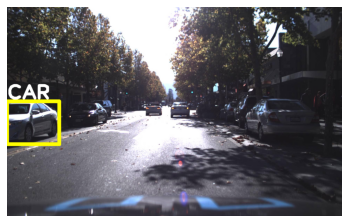

[428 577 535 656]


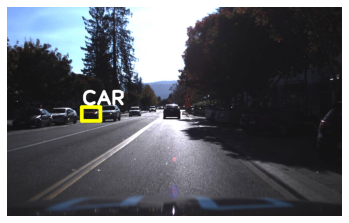

In [26]:
disp_objects_img(test_df.iloc[31], data_path)
disp_objects_img(train_df.iloc[518], data_path)

# Inference and Visualization

#### Visualize Inference on few samples

Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car


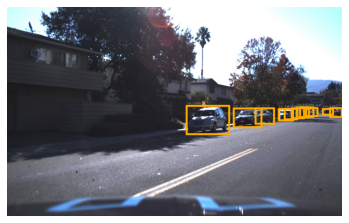

In [71]:
show_detected_objects(test_df.iloc[1], data_path, tfs_client, THRES_SCORE)

Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car


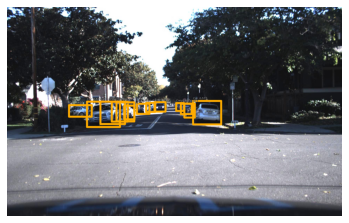

In [74]:
show_detected_objects(test_df.iloc[102], data_path, tfs_client, THRES_SCORE)

#### Perform Inference on the few test images

In [84]:
pred_df = gen_pred_df(test_df[:100], data_path, tfs_client, THRES_SCORE)

Inferenced on 1/98 image
Inferenced on 11/98 image
FPS: 0.077
Inferenced on 21/98 image
FPS: 0.122
Inferenced on 31/98 image
FPS: 0.123
Inferenced on 41/98 image
FPS: 0.12
Inferenced on 51/98 image
FPS: 0.121
Inferenced on 61/98 image
FPS: 0.123
Inferenced on 71/98 image
FPS: 0.122
Inferenced on 81/98 image
FPS: 0.12
Inferenced on 91/98 image
FPS: 0.12
